# WEFE Site Analyst Tool
## implemented in Jupyter Notebook and applied for a Case Study in Costa Rica

This Jupyter Notebook collects environmental and socioeconomic data for the planning of integrated water, energy, food, and environment systems from open servers.

In [1]:
# imports
import os
import pandas as pd
import matplotlib.pyplot as plt
# import files from source
os.chdir("../../src/")
import era5
os.chdir("../examples/Costa Rica")

In [2]:
# initiate earth engine
import ee

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

Enter verification code: 4/1AWgavddkpa7U-GgddKGA_NW_5myIj91D7UuADWXr39unSv31KwvgtpXO1_0

Successfully saved authorization token.


In [18]:
# provide case study name
name = 'turrialba'
# provide input in form of coordinates
lon = -83.616358
lat = 9.830153

In [15]:
# set start and end date (end date will be included
# in the time period for which data is downloaded)
start_date, end_date = '2020-12-31', '2021-12-31'  # time in UTC choose start date one day before time of interest
# for position east of 0° meridian for covering all hours of interest

In [ ]:
# download era5 dataset

variable = "wefesiteanalyst"
target_file = 'era5_wefesiteanalyst_'+name+'.nc'
print(target_file)

ds = era5.get_era5_data_from_datespan_and_position(
    variable=variable,
    start_date=start_date, end_date=end_date,
    latitude=lat, longitude=lon,
    target_file=target_file)

era5_wefesiteanalyst_turrialba.nc


2022-12-15 16:03:25,670 INFO Welcome to the CDS
2022-12-15 16:03:25,672 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2022-12-15 16:03:25,776 INFO Request is queued
2022-12-15 16:03:26,838 INFO Request is running
2022-12-15 16:37:47,274 INFO Request is queued
2022-12-15 16:39:47,569 INFO Request is running


In [11]:
era5_wefe = pd.read_csv(r"wefe.csv")
era5_wefe.head()

,longitude,latitude,time,ssrd,t2m,u10,v10,e,tp,t_air,ghi,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14
0,-83.5,9.75,1/1/2020 0:00,16339.500,289.18842,-0.771638,-0.559500,-2.080000e-06,1.010000e-06,16.038422,4.538750,NaN,NaN,NaN,NaN
1,-83.5,9.75,1/1/2020 1:00,-0.125,288.63270,-0.487984,-0.340697,6.170000e-07,2.770000e-06,15.482697,-0.000035,NaN,NaN,NaN,NaN
2,-83.5,9.75,1/1/2020 2:00,-0.125,288.65717,-0.148256,-0.272024,-2.080000e-08,5.790000e-06,15.507172,-0.000035,NaN,NaN,NaN,NaN
3,-83.5,9.75,1/1/2020 3:00,-0.125,288.49765,0.499541,0.793868,1.220000e-08,2.770000e-06,15.347656,-0.000035,NaN,NaN,NaN,Total Precipitation
4,-83.5,9.75,1/1/2020 4:00,-0.125,288.42474,0.443244,0.853877,-3.280000e-07,5.040000e-07,15.274750,-0.000035,NaN,NaN,NaN,3.37


Text(0, 0.5, 'Irradiance in $W/m^2$')

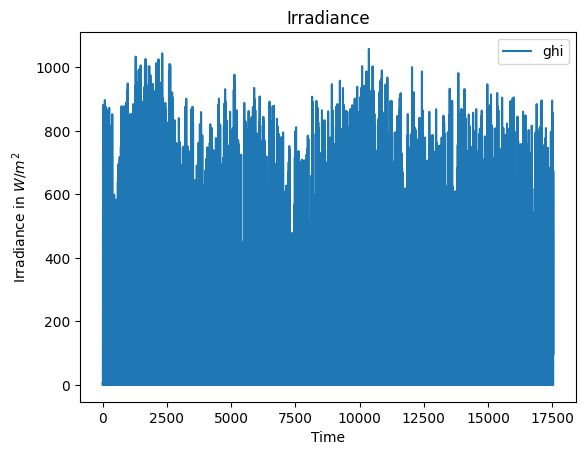

In [12]:
# plot global horizontal irradiance
era5_wefe.loc[:, ['ghi']].plot(title='Irradiance')
plt.xlabel('Time')
plt.ylabel('Irradiance in $W/m^2$')

In [19]:
# SRTM map

# Set the area of interest (AOI)
# You can use the ee.Geometry.Point function to define a point and the ee.Geometry.Buffer function to create a buffer around the point
point = ee.Geometry.Point(lon, lat)
buffer = point.buffer(3000)  # 3 km buffer

# Load the SRTM elevation data
srtm = ee.Image("USGS/SRTMGL1_003")

# Get the elevation at the map center
elevation = ee.Image('USGS/SRTMGL1_003').sample(point)

# Get the elevation value at the map center
elevation_value = elevation.get('elevation').getInfo()

# Print the elevation value
print(f'Elevation at {lon}, {lat}: {elevation_value} meters')

# Make pixels with elevation below sea level transparent.
elv_img = srtm.updateMask(srtm.gt(0))

# Display the thumbnail of styled elevation
from IPython.display import Image

Image(url=elv_img.getThumbURL({
    'min': 0, 'max': 4000, 'dimensions': 512, 'region': buffer,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']}))


Elevation at -83.616358, 9.830153: None meters
